# Wine Rating Prediction and Topic Extraction using NLP

## Introduction

In my previous capstone project-Wine Quality Prediction, I have built models for evaluating the wine quality using supervised machine learning technique.  Through my models, I have drawn conclusions that the random forest model is the best for predicting wine quality. Also, I have given the top three most important features of alcohol, volatile acidity and density (sugar content).  The data set I used for this project was gathered based on the wine physicochemical tests and no any data about grape types, wine brand, wine selling price, wine review and description, country and so on. 

In this final project, I have gathered wine data about alcohol content, wine selling price, wine brand, grape types, country, taster review and so on. Combined with my previous project, I plan to explore how those factors such as grape types and taster review affect wine quality and wine price. The data set has been scraped from Wine Enthusiast. They provide wine description, rating points, wine price, alcohol content, variety, appellation/country, winery, designation, category and so on. 

## Objectives
The objectives of the project are to explore:

1.	The relationship between wine rating points and wine price;
2.	The distribution for wine price with alcohol, wine varity(grape types), country, etc.;
3.	Wine rating prediction using wine description using NLP supervised technique;
4.	Wine topic extraciton for wine recommendation using NLP unsupervised technique; 

## Methodologies
1.	Data collection using Python Scrapy;
2.	Visualization using matplotlib, seaborn, plotly, word cloud, etc.;
3.	Supervised learning: linear regression, random forest algorithm, gradient boost, support vector machines, etc.;
4.	Unsupervised learning: clustering
5.	Natural language Processing: TfidfVect, LSA, LDA, NMF etc.;

The biggest challenge for the project attempts to web scrape data and data preprocess such as data cleaning. 

## Data Gathering
The data gathered for this project was scraped from the website of Wine Enthusiast. The scraper tool used here is Python Scrapy library. The codes were written in Vs Code and scrapy was run in the command line instead of jupyter notebook. Scrapy Xpath expression was used here: The Xpath expression treats nested code like computer file paths, with each level referred to as a 'node'. Also, the CSV file format was used for storing the collected data. Note here, the wine enthusiast website shows the review pages up to 14145. But there are actually less than that many pages and more duplicate outputs. So the pages for this project data set stopped at page 2000. The data set obtained contains 13 columns and 37235 rows of wine reviews. 

The more details about the Scrapy codes, website URL and csv files and so on can be seen in anther folder which has been uploaded on my Github account. 

## Import Library

In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')
import plotly
import squarify
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from collections import Counter
import nltk

sns.set()

## Load Dataset

In [2]:
wine_orig1_df = pd.read_csv('winesreview_new.csv')
wine_orig2_df = pd.read_csv('winesreview_new4.csv')
wine_orig_df = pd.concat([wine_orig1_df, wine_orig2_df], axis=0)
wine_orig_df.index = range(len(wine_orig_df.index))
wine_orig_df.tail(3)

,title,rating_points,description,taster_name,price,designation,variety,appellation,country,winery,alcohol,bottle_size,category
37232,Petit Tracteur 2016 Red (Côtes du Rhône),88,"This flush, full-bodied red is full of juicy b...",Anna Lee C. Iijima,"$15,",NaN,Rhône-style Red Blend,Côtes du Rhône,France,Petit Tracteur,12.50%,750 ml,Red
37233,Pech Merle 2017 Ivy Rosé de Syrah (Petaluma Gap),88,"A 100% stainless-steel fermented quaffer, this...",Virginie Boone,"$25,",Ivy Rosé de,Syrah,Petaluma Gap,US,Pech Merle,14.10%,750 ml,Rose
37234,Quinta Vale Dona Maria 2014 Vintage (Port),88,This Port comes from a good year for single-qu...,Roger Voss,"$84,",Vintage,Port,Port Blend,Portugal,Quinta Vale Dona Maria,20%,750 ml,Port/Sherry


## Clean Data (excluding Text)

In [3]:
# Check original dataset basic info.
print(wine_orig_df.shape)

# Check the dataset has duplicates or not.
# Check "title" column. 
print('unique =',wine_orig_df['title'].nunique())
print('duplicates =',wine_orig_df['title'].duplicated().sum())

(37235, 13)
unique = 31253
duplicates = 5982


The original dataset has 37235 rows and 13 columns, and it also does contain dupicates. Next remove the duplicats from the dataset.

### Remove data set duplicats

In [4]:
# Drop duplicates and rename data set.
wine_raw_df = wine_orig_df.drop_duplicates(subset=['title'])

# check data set info.
wine_raw_df.shape

(31253, 13)

After removing duplicates from title column, the data set has 31253 rows. But it is still necessary to check more duplicates in other columns.

In [5]:
# Check "description" column duplicates.
print('duplicates =',wine_raw_df['description'].duplicated().sum())

# Drop duplicates and rename data set.
wine_raw_df = wine_raw_df.drop_duplicates(subset=['description'])

# check data set info again.
wine_raw_df.shape

duplicates = 11


(31242, 13)

Finally, the data set has 31242 rows without duplicates.

In [6]:
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31242 entries, 0 to 37234
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          31242 non-null  object
 1   rating_points  31242 non-null  int64 
 2   description    31242 non-null  object
 3   taster_name    31004 non-null  object
 4   price          31242 non-null  object
 5   designation    23750 non-null  object
 6   variety        31242 non-null  object
 7   appellation    31242 non-null  object
 8   country        31242 non-null  object
 9   winery         31242 non-null  object
 10  alcohol        30593 non-null  object
 11  bottle_size    31242 non-null  object
 12  category       31242 non-null  object
dtypes: int64(1), object(12)
memory usage: 3.3+ MB


From the above information, the data set has missing values.

In [7]:
# Copy dataset for cleaning the data.
wine_preclean_df = wine_raw_df.copy()

###  Convert string values to numerical

In [8]:
# Clean "price" column and "alcohol" from object to numerical.
wine_preclean_df['price'].head()

0    $29,  
1    $28,  
2    $50,  
3    $60,  
4    $17,  
Name: price, dtype: object

In [9]:
# Clean price type from object to float.
wine_preclean_df['price'] = wine_preclean_df['price'].str.replace(u'\xa0', u'')
wine_preclean_df['price'] = wine_preclean_df['price'].str.replace('$','')
wine_preclean_df['price'] = wine_preclean_df['price'].str.replace(',','')
wine_preclean_df['price'] = wine_preclean_df['price'].str.replace('N/A','NaN')
wine_preclean_df['price'] = wine_preclean_df['price'].astype(float)
wine_preclean_df['price'].head()

0    29.0
1    28.0
2    50.0
3    60.0
4    17.0
Name: price, dtype: float64

In [10]:
# Clean alcohol column.
wine_preclean_df['alcohol'] = wine_preclean_df.alcohol.str.replace('%', '').astype(float)
wine_preclean_df['alcohol'].head()

0    13.5
1    14.9
2    14.5
3    12.9
4    12.5
Name: alcohol, dtype: float64

### Clean missing value and outliers

In [11]:
# Check missing values.
wine_preclean_df.isnull().sum()

title               0
rating_points       0
description         0
taster_name       238
price            1695
designation      7492
variety             0
appellation         0
country             0
winery              0
alcohol           649
bottle_size         0
category            0
dtype: int64

In [12]:
# Drop price and alcohol missing value.
wine_preclean_df = wine_preclean_df.dropna(subset=['price','alcohol'])
wine_preclean_df.isnull().sum()    

title               0
rating_points       0
description         0
taster_name       214
price               0
designation      7001
variety             0
appellation         0
country             0
winery              0
alcohol             0
bottle_size         0
category            0
dtype: int64

In [13]:
# Again check data set info.
wine_preclean_df.shape

(29085, 13)

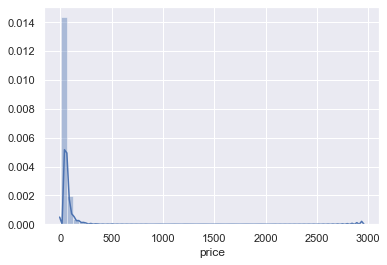

In [14]:
# Find the outliers for price column using Seaborn histgram.
sns.distplot(wine_preclean_df['price'])

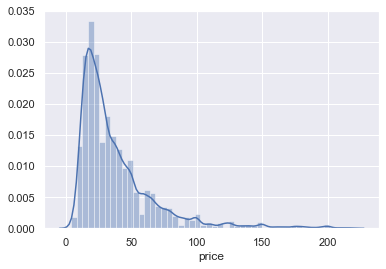

In [15]:
# Remove the outliers for wine price.
q= wine_preclean_df['price'].quantile(0.99)
wine_preclean1_df = wine_preclean_df[wine_preclean_df['price']<q]
sns.distplot(wine_preclean1_df['price'])

In [16]:
wine_preclean1_df.shape

(28790, 13)

In [17]:
# Calculate the percentage for removing data
removedata_percentage = (wine_raw_df.shape[0]-wine_preclean1_df.shape[0])/wine_raw_df.shape[0]*100
removedata_percentage

7.848409192753344

In [18]:
# Check the wine alcohol outliers
wine_preclean1_df['alcohol'].describe()

count    28790.000000
mean        14.113632
std         46.496168
min          1.350000
25%         13.000000
50%         13.500000
75%         14.300000
max       5480.000000
Name: alcohol, dtype: float64

In [19]:
wine_preclean1_df['alcohol'][wine_preclean1_df['alcohol']>30].value_counts().sort_values(ascending=False)

87.0      3
92.0      3
90.0      2
88.0      2
91.0      2
330.0     1
5480.0    1
89.0      1
97.0      1
113.0     1
2017.0    1
2013.0    1
36.0      1
138.0     1
41.0      1
57.0      1
149.0     1
120.0     1
4920.0    1
Name: alcohol, dtype: int64

In [20]:
warnings.filterwarnings('ignore')

# Replace outliers for alcohol content
wine_preclean1_df['alcohol'][wine_preclean1_df['alcohol']>30] = 28
wine_preclean1_df['alcohol'].describe()

count    28790.000000
mean        13.559724
std          1.263626
min          1.350000
25%         13.000000
50%         13.500000
75%         14.300000
max         28.000000
Name: alcohol, dtype: float64

In [21]:
# Check data set info after cleaning outliers and missing value 
print(wine_preclean1_df.shape)
wine_preclean1_df.info()

(28790, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28790 entries, 0 to 37234
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          28790 non-null  object 
 1   rating_points  28790 non-null  int64  
 2   description    28790 non-null  object 
 3   taster_name    28580 non-null  object 
 4   price          28790 non-null  float64
 5   designation    21864 non-null  object 
 6   variety        28790 non-null  object 
 7   appellation    28790 non-null  object 
 8   country        28790 non-null  object 
 9   winery         28790 non-null  object 
 10  alcohol        28790 non-null  float64
 11  bottle_size    28790 non-null  object 
 12  category       28790 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 3.1+ MB


In [22]:
# Copy dataset and rename it again for EDA 
wine_df = wine_preclean1_df.copy()

## Exploratory Data Analysis (EDA)

In [23]:
# Check numerical columns basic info
wine_df.describe()

,rating_points,price,alcohol
count,28790.000000,28790.000000,28790.000000
mean,89.409969,38.300668,13.559724
std,2.912267,30.067492,1.263626
min,80.000000,4.000000,1.350000
25%,87.000000,19.000000,13.000000
50%,90.000000,29.000000,13.500000
75%,91.000000,48.000000,14.300000
max,100.000000,219.000000,28.000000


### 1. Wine price and rating points

In [24]:
# Plot price and rating_points using plotly

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import plotly.graph_objs as go

iplot([go.Scatter(x=wine_df.head(1000)['rating_points'], y=wine_df.head(1000)['price'], mode='markers')])


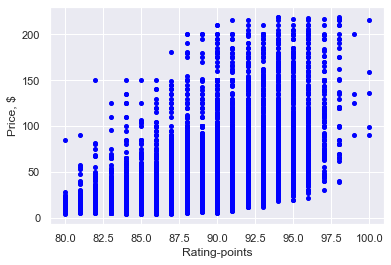

In [25]:
# Plot all the data points for rating_points and price
plt.plot(wine_df['rating_points'], wine_df['price'], 'o', color='blue', markersize=4)
plt.ylabel('Price, $', fontsize=12)
plt.xlabel('Rating-points', fontsize=12)

plt.show()

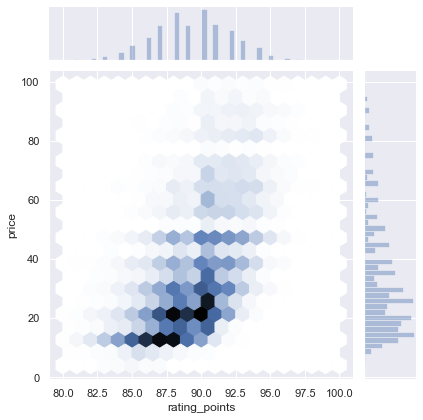

In [26]:
sns.jointplot(x='rating_points', y='price',  data=wine_df[wine_df['price']< 100], kind='hex', gridsize=20)

From the above figure, it can be figured out that the price for most of wines is in the range of \\$10 ~ \\$35. This is reasonable for market needs. And rating points are also most likely in the range of 85 to 92, not very low not very high. 

Further, it can be clearly seen in the above figures, at the same rating points, the price can be varied from low price such as \\$5 to high price \\$150 or even more than \\$200. This indicates that the wine price might be affected by other factors such as wine variety, country and so on and further investigation should be conducted. This is also a good feature for wine consumers because they can buy wines with low price and high rating points. 

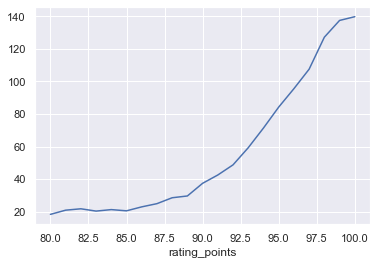

In [27]:
# Explore the relationship between rating_points and price using mean price values.
wine_df.groupby(['rating_points']).price.mean().plot()

From the above mean price with rating_points plot, it can be seen that in general, the wine price increases with rating points. It also can be pointed out that the rating_points in the 80-90, the mean of wine price increases not very much about from \\$20 to \\$39. However, it increases very fast from \\$40 to \\$140 (sharp slope as shown in the figure) after rating_points more than 90. 

### 2. Alcohol and Category

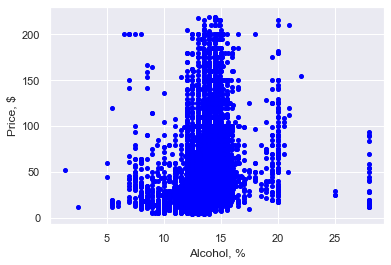

In [28]:
# Plot all the data points for alcohol content and price
plt.plot(wine_df['alcohol'], wine_df['price'], 'o', color='blue', markersize=4)
plt.ylabel('Price, $', fontsize=12)
plt.xlabel('Alcohol, %', fontsize=12)

plt.show()

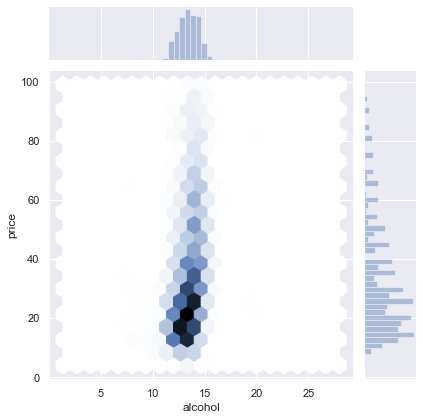

In [29]:
# Plot alcohol with price
sns.jointplot(x='alcohol', y='price',  data=wine_df[wine_df['price'] < 100], kind='hex', gridsize=20)

From the above joint plot, it can be seen that for wine, the most alcohol content is about 10-15% (especially in 11-13%), and price is in the range of 15-40$.

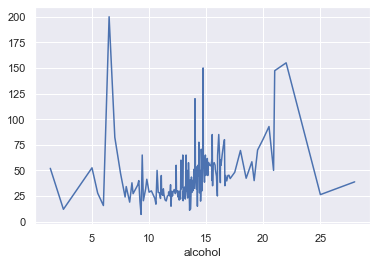

In [30]:
wine_df.groupby(['alcohol']).price.mean().plot()

From this mean price and alcohol figure, it can be seen a trend of price increasing with the alcohol content.

In [31]:
# Check wine category.
print(wine_df['category'].nunique())
wine_df['category'].value_counts()

7


Red            16165
White           9093
Rose            1793
Sparkling       1200
Dessert          346
Port/Sherry      162
Fortified         31
Name: category, dtype: int64

In this dataset, there are seven category for wines. The red wines have the largest number, followed by white and Rose.

In [32]:
# Examine alcohol content for each category.
wine_df.groupby(['category']).alcohol.mean().sort_values()

category
Sparkling      12.070883
Dessert        12.545665
Rose           12.848985
White          13.009861
Red            14.014964
Fortified      17.919355
Port/Sherry    19.224074
Name: alcohol, dtype: float64

In [33]:
# Check the mean price for each category.
wine_df.groupby(['category']).price.mean().sort_values()

category
Rose           20.136079
White          29.438790
Dessert        43.814884
Red            44.294114
Sparkling      45.100000
Fortified      67.225806
Port/Sherry    71.030864
Name: price, dtype: float64

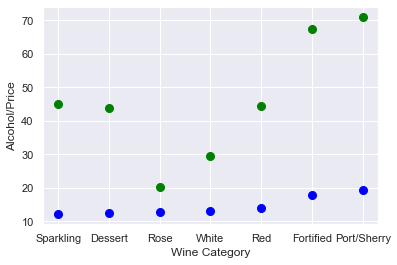

In [34]:
# Plot category with alcohol content and price.
plt.plot(wine_df.groupby(['category']).alcohol.mean().sort_values(),'o', color='blue', markersize=8)
plt.plot(wine_df.groupby(['category']).price.mean().sort_values(), 'o', color='green', markersize=8)
plt.xlabel('Wine Category')
plt.ylabel('Alcohol/Price')

plt.show()

The alcohol content in the Sparkling is lowest and in Port/Sherry highest. Also, in general, the wine price increases with the alcohol content increases. Port/Sherry has highest price. For special wines such as Sparkling and Dessert, they have high price indicating wine price varied and affected by many factors.

### 3. Country

In [35]:
# Gather countries info for wines review.
print(wine_df['country'].nunique())

# Count countries number.
wine_df['country'].value_counts().head(10)

37


US           11429
France        6112
Italy         3820
Spain         1326
Portugal      1251
Austria       1116
Australia      762
Germany        569
Chile          509
Argentina      436
Name: country, dtype: int64

In [53]:
# Map wine produce countries using plotly

df = wine_df['country'].replace("US", "United States").value_counts()

iplot([go.Choropleth(
    locationmode='country names',
    locations=df.index.values,
    text=df.index,
    z=df.values
)])


From the above figure, it can be seen that in this data set, US is the top country for wines review, followed by France and Italy.

                  price
country                
England       67.812500
Canada        63.735294
Peru          43.000000
US            42.982476
Italy         41.634686
Germany       40.198594
Australia     39.401575
France        35.648969
Switzerland   33.666667
South Africa  33.558559


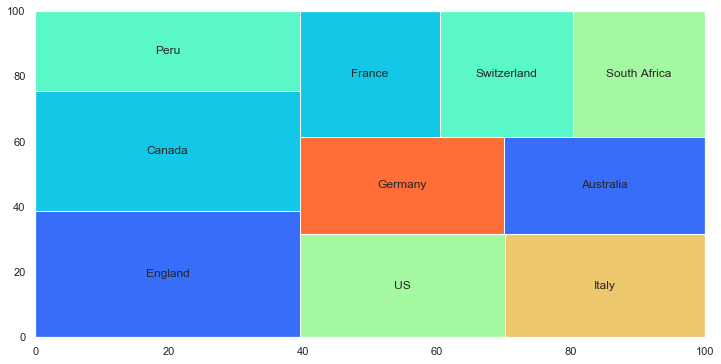

In [37]:
# Examine the mean price of wines for each country.

cp = pd.DataFrame(wine_df.groupby(['country']).price.mean().sort_values(ascending=False))
print(cp.head(10))


# Plot treemap for country and mean price.

import squarify

plt.figure(figsize=(12,6))
squarify.plot(cp['price'].head(10),color=sns.color_palette('rainbow'),label=cp.head(10).index)
plt.show()

From the above analysis, The average price of wine in England is highest, followed by Canada and Peru. US is the fourth expensive country.

### 4. Variety

A variety is the type of grape. It is written here with a lower-case initial. If only one variety is mentioned on the bottle label, then the wine is called varietal and is named after the grape with a capital initial (Riesling, Pinot Noir, etc.). A varietal wine primarily shows the fruit: the grape variety dominates the wine flavour.(From:http://frenchscout.com/types-of-wines)

In [38]:
# Find the number of wine variety or grape types
wine_df['variety'].nunique()

437

There are 437 wine variety.

In [39]:
#wine_df['variety'].unique()

In [40]:
# Calculate wine varity number.
wine_df['variety'].value_counts().head(10)

Pinot Noir                  2875
Chardonnay                  2090
Red Blends                  1960
Cabernet Sauvignon          1737
Rosé                        1422
Bordeaux-style Red Blend    1315
Riesling                    1052
Sauvignon Blanc              995
Syrah                        709
Gamay                        629
Name: variety, dtype: int64

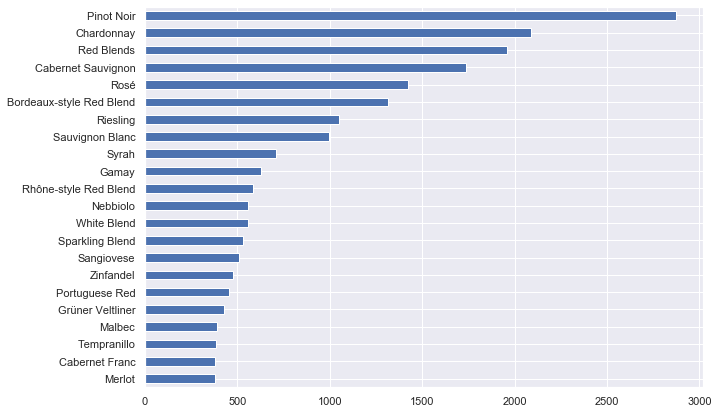

In [41]:
# Plot the wine variety for top 22 variety. 
plt.figure(figsize=(10,7))
wine_df['variety'].value_counts().head(22).sort_values().plot.barh()
plt.show()

Pinot Noir is the first place for making wine. Next is Chardonnay, the third is Red Blends. Cabernet Sauvignon is the fourth place. And Merlot a little bit behind, in 22nd.

In [42]:
# Check most popular regions (US, French and Italy) and grapes
wine_df.groupby(['country']).variety.value_counts().sort_values(ascending=False).head(15)

country   variety                 
US        Pinot Noir                  2252
          Cabernet Sauvignon          1369
          Chardonnay                  1287
France    Bordeaux-style Red Blend     866
Italy     Red Blends                   863
France    Rosé                         745
US        Red Blends                   659
France    Gamay                        626
US        Syrah                        544
Italy     Nebbiolo                     541
US        Zinfandel                    477
Portugal  Portuguese Red               457
France    Chardonnay                   439
Italy     Sangiovese                   427
Austria   Grüner Veltliner             400
Name: variety, dtype: int64

In US, the most three grapes are Pinor Noir, Cabernet Sauvignon and Chardonnay.
In France: Bordeaux-style Red Blend, Rosé, and Gamay.
In Italy: Red Blends, Nebbiolo, Sangiovese.

In [43]:
# Examine the relationship between varity and price.
wine_df.groupby(['variety']).price.describe().sort_values(['count'],ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Pinot Noir,2875.0,49.720337,27.005393,5.0,30.0,46.0,62.0,203.0
Chardonnay,2090.0,39.490416,27.210136,5.0,21.0,35.0,50.0,200.0
Red Blends,1960.0,36.265556,27.483261,5.0,18.0,28.0,45.0,218.0
Cabernet Sauvignon,1737.0,58.039724,45.472229,5.0,24.0,44.0,80.0,219.0
Rosé,1422.0,20.082271,10.004551,5.0,15.0,18.0,24.0,160.0
Bordeaux-style Red Blend,1315.0,47.289726,39.651843,8.0,20.0,35.0,58.0,219.0
Riesling,1052.0,35.136882,26.523678,5.0,19.0,27.0,42.0,200.0
Sauvignon Blanc,995.0,23.664322,13.876644,4.0,15.0,20.0,28.0,115.0
Syrah,709.0,50.287729,30.691266,4.0,32.0,44.0,59.0,205.0


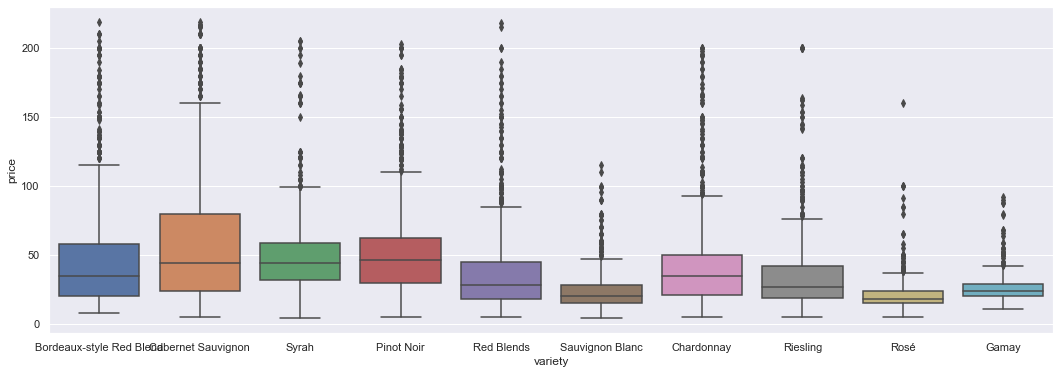

In [44]:
# Examine the relationship for varity and rating points.
variety_df = wine_df[wine_df['variety'].isin(wine_df['variety'].value_counts().head(10).index)]

plt.figure(figsize=(18,6))
sns.boxplot(x='variety',y='price', data=variety_df)

plt.show()

From the above price boxplot, the average price for most popular wines is in the range of \\$20 to \\$50 indicating there are not very expensive and suitable for the market and most consumers' needs.

In [45]:
# Examine the relationship for varity and rating points.
wine_df.groupby(['variety']).rating_points.describe().sort_values(['count'],ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Pinot Noir,2875.0,90.560000,2.708424,80.0,89.0,91.0,92.0,99.0
Chardonnay,2090.0,89.464593,3.041116,80.0,87.0,90.0,92.0,98.0
Red Blends,1960.0,88.771939,2.664023,81.0,87.0,89.0,90.0,99.0
Cabernet Sauvignon,1737.0,89.222222,2.998293,80.0,87.0,90.0,91.0,100.0
Rosé,1422.0,87.714487,2.300764,80.0,86.0,88.0,89.0,95.0
Bordeaux-style Red Blend,1315.0,89.671483,3.045330,80.0,88.0,90.0,92.0,100.0
Riesling,1052.0,91.049430,2.962087,81.0,89.0,91.0,93.0,98.0
Sauvignon Blanc,995.0,88.298492,2.664761,80.0,86.0,88.0,90.0,96.0
Syrah,709.0,90.514810,3.058538,80.0,88.0,91.0,93.0,100.0


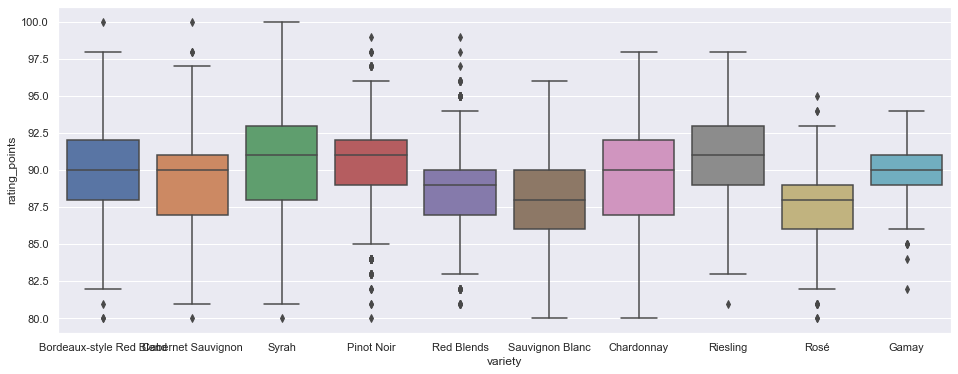

In [46]:
# Examine the relationship for varity and rating points.
variety_df = wine_df[wine_df['variety'].isin(wine_df['variety'].value_counts().head(10).index)]

plt.figure(figsize=(16,6))

sns.boxplot(x='variety',y='rating_points', data=variety_df)

plt.show()

The rating_points for most wines is in the range of (86 ~ 93).

For the same wine variety, the price and rating_points are various from low to high. This also gives a good sign for wine consumers that they can buy all kinds of wines with good quality at low price. 

### 5. Taster

In this data set, the description for wines is written by wine tasters. In the following sections, I will conduct analysis on wine tasters and the description they wrote to explore how their reviews affect wine rating points and how their reviews can affect the wine consumers' decisions to buy or not buy wines.

In [47]:
# Check numbers of the taster and their names in the data set.
print(wine_df['taster_name'].nunique())
wine_df['taster_name'].unique()

19


array(['Anne Krebiehl\xa0MW', 'Matt Kettmann', 'Virginie Boone',
       'Christina Pickard', 'Roger Voss', 'Jim Gordon',
       'Anna Lee C. Iijima', 'Paul Gregutt', 'Kerin O’Keefe',
       'Sean P. Sullivan', 'Alexander Peartree', 'Susan Kostrzewa',
       'Mike DeSimone', nan, 'Jeff Jenssen', 'Lauren Buzzeo',
       'Michael Schachner', 'Fiona Adams', 'Carrie Dykes',
       'Joe Czerwinski'], dtype=object)

In [48]:
# Check missing values
wine_df['taster_name'].isnull().sum()

210

In total, there have 19 tasters to provide the wine description. Note here, there still some missing values (nan) in taster_name but for simplifying the analysis these missing values were ignored. 

In [49]:
# Find the number of wine description given by tasters.
wine_df['taster_name'].value_counts()

Roger Voss            5687
Kerin O’Keefe         3380
Virginie Boone        2917
Matt Kettmann         2789
Michael Schachner     2350
Jim Gordon            1882
Anne Krebiehl MW      1864
Paul Gregutt          1561
Sean P. Sullivan      1461
Anna Lee C. Iijima    1312
Christina Pickard     1105
Alexander Peartree     717
Lauren Buzzeo          444
Mike DeSimone          330
Fiona Adams            243
Jeff Jenssen           207
Susan Kostrzewa        166
Carrie Dykes            88
Joe Czerwinski          77
Name: taster_name, dtype: int64

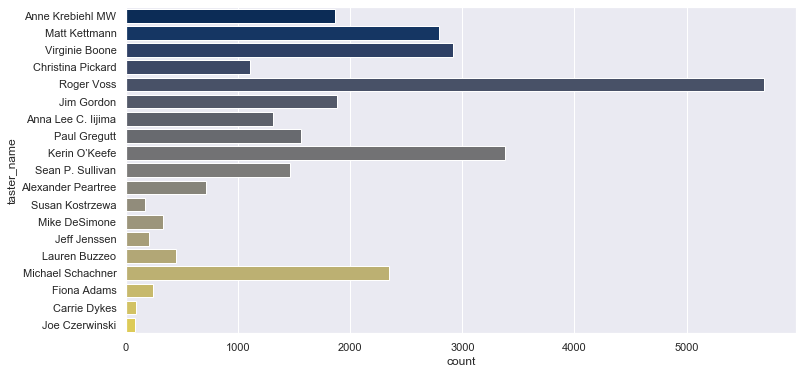

In [50]:
# Plot taster's count.
plt.figure(figsize=(12,6))
sns.countplot(y = wine_df['taster_name'], palette = 'cividis')

From the above countplot, Roger Voss is the leading taster for wine reviews. He has written 5687 wine descriptions in this data set. I will use his descriptions for topic extraction analysis as an example to explore how wine consumers can make decisions based on his wine reviews.

In [51]:
# Check rating points info given by each taster.
wine_df.groupby(['taster_name']).rating_points.describe().sort_values(['count'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
taster_name,,,,,,,,
Roger Voss,5687.0,89.250923,2.758064,82.0,87.0,89.0,91.0,100.0
Kerin O’Keefe,3380.0,89.663018,2.725217,82.0,88.0,89.0,91.0,99.0
Virginie Boone,2917.0,90.235173,2.996836,80.0,88.0,90.0,92.0,99.0
Matt Kettmann,2789.0,90.331302,2.505652,82.0,88.0,90.0,92.0,97.0
Michael Schachner,2350.0,87.249787,3.195781,80.0,85.0,87.0,90.0,95.0
Jim Gordon,1882.0,88.909671,2.721979,81.0,87.0,89.0,91.0,100.0
Anne Krebiehl MW,1864.0,91.195279,2.450467,84.0,89.0,91.0,93.0,98.0
Paul Gregutt,1561.0,90.051249,2.425545,81.0,88.0,90.0,92.0,97.0
Sean P. Sullivan,1461.0,88.719370,2.647167,80.0,87.0,88.0,91.0,98.0


In [52]:
# Check wine price info given by each taster.
wine_df.groupby(['taster_name']).price.describe().sort_values(['count'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
taster_name,,,,,,,,
Roger Voss,5687.0,34.877264,31.374017,4.0,16.0,24.0,40.00,215.0
Kerin O’Keefe,3380.0,43.206065,35.390306,7.0,20.0,30.0,55.00,218.0
Virginie Boone,2917.0,59.568392,37.389002,7.0,35.0,50.0,75.00,219.0
Matt Kettmann,2789.0,42.677920,21.570099,6.0,28.0,40.0,50.00,200.0
Michael Schachner,2350.0,28.626383,26.702275,4.0,14.0,20.0,30.75,200.0
Jim Gordon,1882.0,28.197131,17.489237,4.0,16.0,25.0,35.00,165.0
Anne Krebiehl MW,1864.0,32.977736,20.085223,10.0,20.0,25.0,40.00,171.0
Paul Gregutt,1561.0,41.465727,22.412371,8.0,25.0,35.0,55.00,195.0
Sean P. Sullivan,1461.0,39.017112,24.833315,5.0,23.0,35.0,48.00,200.0


Both rating points and price given by each taster are varied. This indicates the complexity of wine review and wine price on one hand. The winemakers and wine consumers can get more information and find good deals from tasters' wine description on the other hand.

## Natural Language Processing (NLP) Models

The column of description is given by wine tasters and it is text file. In this project, I will focus on the text data and use natural language processing (NLP) to build supervised models to explore the relationships between wines description and wines rating points. Also, I will use the wine description to perform unsupervised topic exaction to test whether it helps wine consumers to make decision to buy wines and drink now or keep them for later drink.

In [253]:
# Examine the decription column basic info.
print(wine_df.shape[0])
print(wine_df['description'].isnull().sum())
pd.options.display.max_colwidth = 150
wine_df[['description','taster_name']].head()

28790
0


,description,taster_name
0,"Subtle hints of mandarin peel have a floral overtone on the nose of this wine. The palate offers rich creaminess that counters the phenolic, pithy...",Anne Krebiehl MW
1,"Candied raspberry and cranberry aromas meet with dried hibiscus, purple flowers and a touch of baked pastry on the nose of this single-vineyard ex...",Matt Kettmann
2,"This wine is a blend of 35% Cabernet Sauvignon, 33% Merlot and 32% Petit Verdot, all estate grown. Moderate red fruit and supple tannins wrap arou...",Virginie Boone
3,"Crisp and clean lines of lemon rind and a light, doughy yeast aroma kick off the enlivening nose of this bottling. The fine mousse on the palate d...",Matt Kettmann
4,"This is a fairly worked but solid example of an oak-aged Sauvignon. Partially wild fermented in a combo of oak barrels, it leads with subtle notes...",Christina Pickard


In [254]:
# Check the description info for taster-Roger Voss.
#pd.options.display.max_colwidth =None
wine_df['description'][wine_df.taster_name=='Roger Voss'].tail(3)

37210    This blend of 80% Merlot and 20% Cabernet Franc is ripe, showing red-berry flavors and an excellent potential. Made from organically grown grapes,...
37218                                  This wine is light in body but heavily perfumed. Clean fruit shows on the palate, with an addition of geranium aromas. 
37234    This Port comes from a good year for single-quinta vintages. Made in open stone lagars, it is a ripe, black-fruited wine, packed with sweet plums ...
Name: description, dtype: object

### Text Data Cleaning

In [255]:
import re
from nltk.corpus import stopwords
from collections import Counter
import nltk
#import spacy
#import string

In this project, during the text pre-processing what I am going to do: 
* Lowercase
* Removing stopwords, bracket, punctuation and numbers

Not to going to use: Lemmatization and Stemming. Stemming removes the last few characters in a word, often leading to incorrect meanings and spelling errors, or making the words un-recognizable. And lemmatization also cause some un-recognizable words, for example: nerthe, proffer, petaluma etc.

I should try not to do too much of text pre-processing for the description text, because most of the description are short (less than 300 words), removing more words risks of losing meaning.

In [256]:
# Clean text data
wine_df['description_c']= wine_df['description'].copy()
wine_df['description_c'] = wine_df['description_c'].str.lower()
wine_df['description_c'] = wine_df['description_c'].str.replace('-','')
wine_df['description_c'] = wine_df['description_c'].str.replace('/','')
wine_df['description_c'] = wine_df['description_c'].str.replace(r'w*\d\w*','')
wine_df['description_c'] = wine_df['description_c'].str.replace('%','')
wine_df['description_c'] = wine_df['description_c'].str.replace(r'[\[].*?[\]]','')
wine_df['description_c'] = wine_df['description_c'].str.replace(r'\t\n\r\f\v','')

wine_df['description_c'] = wine_df['description_c'].str.strip()
wine_df['description_c'].head(3)

0    subtle hints of mandarin peel have a floral overtone on the nose of this wine. the palate offers rich creaminess that counters the phenolic, pithy...
1    candied raspberry and cranberry aromas meet with dried hibiscus, purple flowers and a touch of baked pastry on the nose of this singlevineyard exp...
2    this wine is a blend of  cabernet sauvignon,  merlot and  petit verdot, all estate grown. moderate red fruit and supple tannins wrap around touche...
Name: description_c, dtype: object

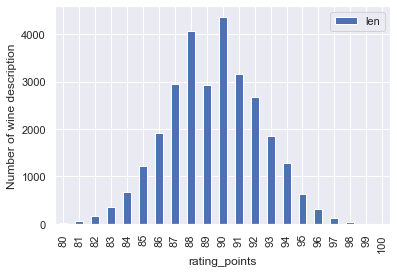

In [257]:
# check at the same rating points how many wines descriptions there have.
wine_df.groupby(['rating_points']).description.agg([len]).plot.bar()
plt.ylabel('Number of wine description', fontsize=12)
plt.show()

The distribution between rating_points and wine description seems normal distribution as shown in the above figure. 

Now let's take a look what is relationship between these two parameters. In other words, we will build supervised machinge learning models to predict the rating points for a certain wine using wine description.

###  1. Supervised NLP models

In this supervised learning models, the description text column is used as independent variable and rating_points as target varible.The target variable-rating_points is numerical hence several regression algorithms will be applied here. 

    Linear algorithms:  - Linear Regression 
                        - Ridge Regression 
                        - Lasso Regression 
                        - ElasticNet Regression
                   
    Nonlinear algorithms: - Random Forest,  
                          - GradientBoosting,  
                          - Support Vector Machines

GridSearchCV was used to tune hyperparameters. Cross validation and metrics were applied for evaluating the models.

For the supervised models, the first step is feature engineering to convert text data into numerical form. Here, both Bag of Words (BoW) and TF-IDF from scikit-learn library were used to create document-term matrices. The scores from both techniques were compared and then decided which technique to be select for supervised models. 

#### BOW and TF-IDF
Now let's take a look feature engineering step: CountVectorizer (BOW) and TfidfVectorizer (TF-IDF). Also, it is worth mentioning here that for tuning CountVectorizer and TfidfVectorizer hyperparameters ngram_range, max_features, max_df and min_df were considered. The details about tuning those parameters are not shown here. And the parameters as displayed in the following sections are the best results through tuning step.   

In [157]:
# BOW 

from sklearn.feature_extraction.text import CountVectorizer
Y1 = wine_df['rating_points']
x1 = wine_df['description_c']

cvect = CountVectorizer(stop_words='english',
                    lowercase=True,
                    analyzer='word', 
                    max_df=1.0, 
                    min_df=5,
                    ngram_range=(1, 1),
                    max_features=2250,
                    vocabulary=None, 
                    binary=False)

X1 = cvect.fit_transform(x)
print("Number of features: %d" % X1.get_shape()[1])
X1.shape

#print(cvect.get_feature_names())

# Linear regression model used here for comparing BOW and TF-IDF

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# We split the dataset into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.25, random_state=123)
print("The number of observations in training set is {}".format(X1_train.shape[0]))
print("The number of observations in test set is {}".format(X1_test.shape[0]))

# Models
lrm = LinearRegression()

lrm.fit(X1_train, y1_train)

#score = cross_val_score(lr, X_train, y_train, cv=5)

#print("-------------------Linear Regression Scores by BOW------------------")
#print(score)
#print("\nAccuracy for train set: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
#print('\nTraining set score:', lrm.score(X1_train, y1_train))
#print('\nTest set score:', lrm.score(X1_test, y1_test))

Number of features: 2250
The number of observations in training set is 21592
The number of observations in test set is 7198


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [158]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
Y = wine_df['rating_points']
x = wine_df['description_c']

tfv = TfidfVectorizer(stop_words='english',
                    lowercase=True,
                    analyzer='word', 
                    max_df=1.0, 
                    min_df=1,
                    ngram_range=(1, 1),
                    max_features=2250,
                    vocabulary=None, 
                    binary=False)

X = tfv.fit_transform(x1)

# Getting the word list.
terms = tfv.get_feature_names()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# Models
lr = LinearRegression()

lr.fit(X_train, y_train)
y_preds_test = lr.predict(X_test)

#print("-----------------Linear Regression Scores by TF-IDF------------------")
#print('Training set score:', lr.score(X_train, y_train))
#print('\nTest set score:', lr.score(X_test, y_test))

The number of observations in training set is 21592
The number of observations in test set is 7198


#### Findings for BOW and TF-IDF

In [159]:
print("---------------Linear Regression Scores by BOW----------------")
print('Training set score_BOW:%0.3f' % lrm.score(X1_train, y1_train))
print('\nTest set score_BOW:%0.3f' % lrm.score(X1_test, y1_test))
print("\n-------------Linear Regression Scores by TF-IDF-------------")
print('Training set score_TFIDF:%0.3f' % lr.score(X_train, y_train))
print('\nTest set score_TFIDF:%0.3f' % lr.score(X_test, y_test))

---------------Linear Regression Scores by BOW----------------
Training set score_BOW:0.700

Test set score_BOW:0.626

-------------Linear Regression Scores by TF-IDF-------------
Training set score_TFIDF:0.709

Test set score_TFIDF:0.641


From the above results, it can be seen that the training set scores are similar for both methods but the test set score for TF-IDF of 0.641 is higher than that of BOW 0.626. This indicates less overfitting problem for TF_IDF method. Therefore,TF-IDF model is better than BOW.

In the following section, only TF-IDF technique was applied to build supervised models.

#### Linear Regression

In [185]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm

Y = wine_df['rating_points']
x = wine_df['description_c']

tfv = TfidfVectorizer(stop_words='english',
                    lowercase=True,
                    analyzer='word', 
                    max_df=1.0, 
                    min_df=1,
                    ngram_range=(1, 1),
                    max_features=2250,
                    vocabulary=None, 
                    binary=False)

X = tfv.fit_transform(x1)

# Getting the word list.
terms= tfv.get_feature_names()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123)

import time
start_time_lr = time.perf_counter()

# Models
lr = LinearRegression()

lr.fit(X_train, y_train)
y_preds_test_l = lr.predict(X_test)

runtime_lr = time.perf_counter() - start_time_lr
print("Runtime_lr: {} Seconds".format(runtime_lr))

Runtime_lr: 0.28346249999594875 Seconds


#### Ridge Linear Regression 

In [186]:
from sklearn.linear_model import RidgeCV

# RidgeCV model
start_time_r = time.perf_counter()

alphas = [np.power(10.0,p) for p in np.arange(-10,10,1)]
ridge_reg = RidgeCV(alphas=alphas, cv=5)


ridge_reg.fit(X_train, y_train)

y_preds_train_r = ridge_reg.predict(X_train)
y_preds_test_r = ridge_reg.predict(X_test)

runtime_ridgecv = time.perf_counter() - start_time_r
print("Runtime_ridgecv: {} Seconds".format(runtime_ridgecv))

Runtime_ridgecv: 3.964033099997323 Seconds


#### Lasso Linear Regression

In [187]:
# LassoCV model

from sklearn.linear_model import LassoCV
start_time_la = time.perf_counter()

alphas = [np.power(10.0,p) for p in np.arange(-10,10,1)]
lasso_reg = LassoCV(alphas=alphas, cv=5)

lasso_reg.fit(X_train, y_train)

y_preds_train_la = lasso_reg.predict(X_train)
y_preds_test_la = lasso_reg.predict(X_test)

runtime_lassocv = time.perf_counter() - start_time_la
print("Runtime_lassocv: {} Seconds".format(runtime_lassocv))

Runtime_lassocv: 585.9163326999987 Seconds


#### ElasticNet Regression

In [188]:
# ElasticNetCV Model.
from sklearn.linear_model import ElasticNetCV

start_time_e = time.perf_counter()

alphas = [np.power(10.0,p) for p in np.arange(-10,10,1)]
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

y_preds_train_e = elasticnet_cv.predict(X_train)
y_preds_test_e = elasticnet_cv.predict(X_test)

runtime_elasticnetcv = time.perf_counter() - start_time_e
print("Runtime_elasticnetcv: {} Seconds".format(runtime_elasticnetcv))

Runtime_elasticnetcv: 867.2583616999909 Seconds


#### Findings for Linear Algorithms

In [189]:
# Linear, Lasso, Ridge, ElasticNet models running results.
print("----------------------Linear Regression ----------------------")
print("Runtime_lr: {} Seconds".format(runtime_lr))
print("----------------------------------------")
print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
print("----------------------------------------")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test_l)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_l)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_l)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_l) / y_test)) * 100))

print("\n----------------------Ridge Regression----------------------")
print("Best alpha using built-in RidgeCV: {}".format(ridge_reg.alpha_))
print("----------------------------------------")
print("Runtime_ridgecv: {} Seconds".format(runtime_ridgecv))
print("----------------------------------------")
print("R-squared of the model in the training set is: {}".format(ridge_reg.score(X_train, y_train)))
print("R-squared of the model in the test set is: {}".format(ridge_reg.score(X_test, y_test)))
print("----------------------------------------")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test_r)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_r)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_r)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_r) / y_test)) * 100))

print("\n----------------------Lasso Regression ----------------------")
print("Best alpha using built-in LassoCV: {}".format(lasso_reg.alpha_))
print("----------------------------------------")
print("Runtime_lassocv: {} Seconds".format(runtime_lassocv))
print("R-squared of the model on the training set is: {}".format(lasso_reg.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(lasso_reg.score(X_test, y_test)))
print("----------------------------------------")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test_la)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_la)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_la)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_la) / y_test)) * 100))

print("\n----------------------ElasticNet Regression ----------------------")
print("Best alpha using built-in ElasticNetCV: {}".format(elasticnet_cv.alpha_))
print("----------------------------------------")
print("Runtime_elasticnetcv: {} Seconds".format(runtime_elasticnetcv))
print("----------------------------------------")
print("R-squared of the model on the training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("----------------------------------------")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test_e)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_e)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_e)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_e) / y_test)) * 100))

----------------------Linear Regression ----------------------
Runtime_lr: 0.28346249999594875 Seconds
----------------------------------------
R-squared of the model in the training set is: 0.7091128736876144
R-squared of the model in the test set is: 0.6411620738702752
----------------------------------------
Mean absolute error of the prediction is: 1.381117757230739
Mean squared error of the prediction is: 3.0903914251892233
Root mean squared error of the prediction is: 1.7579509166041078
Mean absolute percentage error of the prediction is: 1.5452956668551254

----------------------Ridge Regression----------------------
Best alpha using built-in RidgeCV: 1.0
----------------------------------------
Runtime_ridgecv: 3.964033099997323 Seconds
----------------------------------------
R-squared of the model in the training set is: 0.6976799888524905
R-squared of the model in the test set is: 0.6424840579458727
----------------------------------------
Mean absolute error of the predicti

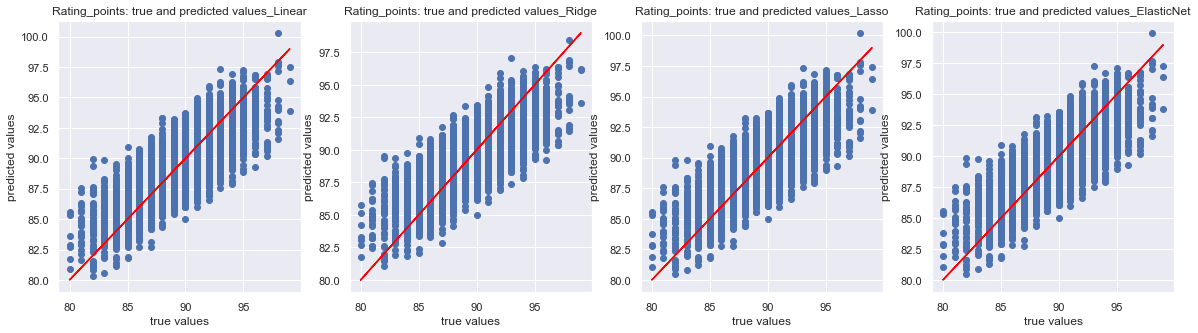

In [190]:
# Plot rating points true value and predict value for the test set.
plt.figure(figsize= (20,5))
plt.subplot(1, 4, 1)
plt.scatter(y_test, y_preds_test_l)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Rating_points: true and predicted values_Linear")

plt.subplot(1, 4, 2)
plt.scatter(y_test, y_preds_test_r)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Rating_points: true and predicted values_Ridge")

plt.subplot(1, 4, 3)
plt.scatter(y_test, y_preds_test_la)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Rating_points: true and predicted values_Lasso")

plt.subplot(1, 4, 4)
plt.scatter(y_test, y_preds_test_e)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Rating_points: true and predicted values_ElasticNet")

plt.show()

From the above figures and the results, mean absolute percentage error of the prediction is about 1.54% indicating that the linear algorithm for predicting rating points using description variable is a good technique to be used here.

Next, let's take a look four linear models.

In [169]:
# Check coeffcient info for Linear, Ridge, Lasso and ElasticeNet
pd.DataFrame(lr.coef_.reshape(1,-1), columns= terms).transpose().sort_values(0)

,0
lacks,-3.953828
flabby,-3.794696
forced,-3.638825
disjointed,-3.530187
harsh,-3.450923
...,...
decades,7.888571
beauty,7.953555
stellar,8.019297
tremendous,8.599866


In [170]:
pd.DataFrame(ridge_reg.coef_.reshape(1,-1), columns= terms).transpose().sort_values(0)

,0
lacks,-4.386435
disjointed,-3.881557
harsh,-3.875783
forced,-3.712372
flat,-3.635938
...,...
impressive,5.780417
complex,6.231035
stunning,6.463000
superb,6.606396


In [174]:
pd.DataFrame(lasso_reg.coef_.reshape(1,-1), columns= terms).transpose().sort_values(0)

,0
lacks,-4.081710
flabby,-3.841528
forced,-3.738923
disjointed,-3.685351
harsh,-3.598435
...,...
decades,7.778693
beauty,7.811347
stellar,7.839913
tremendous,8.434458


In [175]:
pd.DataFrame(elasticnet_cv.coef_.reshape(1,-1), columns= terms).transpose().sort_values(0)

,0
lacks,-4.126465
flabby,-3.797442
forced,-3.747082
disjointed,-3.724315
harsh,-3.642348
...,...
decades,7.514681
beauty,7.517487
stunning,7.553724
tremendous,8.056197


In [177]:
coeff_used_lr = np.sum(lr.coef_!=0)
print('coeff_used_lr = {}'.format(np.sum(lr.coef_!=0)))
print('coeff_used_ridge = {}'.format(np.sum(ridge_reg.coef_!=0)))
print('coeff_used_lasso = {}'.format(np.sum(lasso_reg.coef_!=0)))
print('coeff_used_elasticnet = {}'.format(np.sum(elasticnet_cv.coef_!=0)))

coeff_used_lr = 2250
coeff_used_ridge = 2250
coeff_used_lasso = 2215
coeff_used_elasticnet = 2237


#### Summary for Linear Algorithms

In [191]:
# Compare linear models. 
Linear_comparison = pd.DataFrame({
    'Model':['Linear', 'Ridge','Lasso', 'Elasticnet'],
    'R-squared_train':[lr.score(X_train, y_train), ridge_reg.score(X_train, y_train), 
                       lasso_reg.score(X_train, y_train), elasticnet_cv.score(X_train, y_train)],
    'R-squared_test':[lr.score(X_test, y_test), ridge_reg.score(X_test, y_test), 
                      lasso_reg.score(X_test, y_test), elasticnet_cv.score(X_test, y_test)],
    'MAPError':[np.mean(np.abs((y_test - y_preds_test_l) / y_test)) * 100,
                np.mean(np.abs((y_test - y_preds_test_r) / y_test)) * 100,
                np.mean(np.abs((y_test - y_preds_test_la) / y_test)) * 100,
                np.mean(np.abs((y_test - y_preds_test_e) / y_test)) * 100
                ],
    'No of Coefficient used':[np.sum(lr.coef_!=0), np.sum(ridge_reg.coef_!=0),
                              np.sum(lasso_reg.coef_!=0), np.sum(elasticnet_cv.coef_!=0)],
    'lamdel':[0, 1.0, 1e-05, 1e-05]
}, columns=['Model','R-squared_train', 'R-squared_test','MAPError','No of Coefficient used', 'lamdel'])

Linear_comparison.sort_values(by='R-squared_test', ascending=False)

,Model,R-squared_train,R-squared_test,MAPError,No of Coefficient used,lamdel
3,Elasticnet,0.708475,0.643128,1.540468,2237,0.00001
1,Ridge,0.697680,0.642484,1.541100,2250,1.00000
2,Lasso,0.708828,0.641939,1.543196,2215,0.00001
0,Linear,0.709113,0.641162,1.545296,2250,0.00000


From the above linear algorithms model comparison table, it can be figured out that R-squares for test set and train set are   about 0.71 and 0.64, respectively. Mean absolute percentage error of the prediction is also similar and about 1.54. There has no big differences among four models and Elasticnet model has slightly higher value compared with other three models.

However, the numbers of coefficient used in the four models are different. Also coefficients for all of features also look different. Simple Linear regression used all of features of 2250. Ridge also used 2250. Both Lasso and ElasticNet reduced features number used in the model from 2250 to 2215 and 2237 as shown in the table.

Further, from the coefficient results, Ridge, Lasso and ElasticNet did decrease the coefficients values. Ridge has obvious reduction. Lasso and ElasticNet slightly reduced the values. 

Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression. Compared with the simple linear regression model, ridge regression with lambel of 1.0 shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity.

In Lasso linear model, lamdel is 1e-5 not very high, but we still can see some features for this technique. Firstly, Lasso linear regression had a little bit higher R-square value for test set. Secondly, it still slightly reduced the coefficient for all of the features compared with the simple linear regression model. Lastly, it also reduced the features from 2250 to 2215 used in the model. This confirms that Lasso regression not only helps in reducing over-fitting but it can help us in feature selection. In other words, Lasso somehow can help optimize the model.

ElasticNet (lamdel=1e-5) is the combined by Ridge and Lasso. Hence, the results from this model are in between of Ridge and Lasso. It also helps reducing over-fitting and selecting features.

reference: https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

#### Non-Linear Algorithm

Random Forest, GradientBoosting, and Support Vector Machines will be applied here to build non-linear models.

It is worth noting here for these three algorithms, GridSearchCV was used to tune hyperparameters. The codes of GridSearchCV were given in the last section of this notebook because it took several hours to run GridSearchCV for each model. The parameters in the models given in the following section are the final parameters obtained from tuning process.

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer
Y = wine_df['rating_points']
x = wine_df['description_c']

tfv = TfidfVectorizer(stop_words='english',
                    lowercase=True,
                    analyzer='word', 
                    max_df=1.0, 
                    min_df=1,
                    ngram_range=(1, 1),
                    max_features=2250,
                    vocabulary=None, 
                    binary=False)

X = tfv.fit_transform(x1)

# Getting the word list.
terms = tfv.get_feature_names()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 21592
The number of observations in test set is 7198


#### Random Forest

In [206]:
# Random Forest
start_time_rfr = time.perf_counter()

rfr = RandomForestRegressor(n_estimators=400,
                            max_depth=10,
                            min_samples_split=10
                            )

rfr.fit(X_train, y_train)
y_preds_test_rfr = rfr.predict(X_test)

runtime_rfr = time.perf_counter() - start_time_rfr
print("Runtime_rfr: {} Seconds".format(runtime_rfr))

Runtime_rfr: 165.04901800000516 Seconds


#### Gradient Boosting

In [208]:
# Gradient Boosting
start_time_gbr = time.perf_counter()

gbr = GradientBoostingRegressor(n_estimators=400,
                                max_depth=10,
                                min_samples_split=10
                               )
gbr.fit(X_train, y_train)
y_preds_test_gbr = gbr.predict(X_test)

runtime_gbr = time.perf_counter() - start_time_gbr
print("Runtime_gbr: {} Seconds".format(runtime_gbr))

Runtime_gbr: 157.98455100000137 Seconds


#### Support Vector Machines

In [210]:
# Support Vector Machines
start_time_svr = time.perf_counter()

svr = SVR(kernel = 'linear', C=10)
svr.fit(X_train, y_train)
y_preds_test_svr = svr.predict(X_test)

runtime_svr = time.perf_counter() - start_time_svr
print("Runtime: {} Seconds".format(runtime_svr))

Runtime: 428.40640669999993 Seconds


#### Findings for Non-Linear Algorithms

In [213]:
print("----------------------Random Forest Scores----------------------")
print("Runtime_rfr: {} Seconds".format(runtime_rfr))
print('Training set score:', rfr.score(X_train, y_train))
print('Test set score:', rfr.score(X_test, y_test))

print("\n----------------------Gradient Boosting Scores----------------------")
print("Runtime_gbr: {} Seconds".format(runtime_gbr))
print('Training set score:', gbr.score(X_train, y_train))
print('Test set score:', gbr.score(X_test, y_test))

print("\n----------------------Support Vector Machines Scores----------------------")
print("Runtime_svr: {} Seconds".format(runtime_svr))
print('Training set score:', svr.score(X_train, y_train))
print('Test set score:', svr.score(X_test, y_test))

----------------------Random Forest Scores----------------------
Runtime_rfr: 165.04901800000516 Seconds
Training set score: 0.3867043036953588
Test set score: 0.32736428524873473

----------------------Gradient Boosting Scores----------------------
Runtime_gbr: 157.98455100000137 Seconds
Training set score: 0.8989692930967212
Test set score: 0.6221374285516514

----------------------Support Vector Machines Scores----------------------
Runtime_svr: 428.40640669999993 Seconds
Training set score: 0.6920470169469692
Test set score: 0.6283777992780368


#### Summary for Linear and Non-Linear Algorithms

In [218]:
# Compare linear and non-linear models. 
model_comparison = pd.DataFrame({
    'Model':['ElasticNet Linear', 'Random Forest','Gradient Boosting', 'Support Vector Machines'],
    'Accuracy_train':[elasticnet_cv.score(X_train, y_train), rfr.score(X_train, y_train), 
                       gbr.score(X_train, y_train), svr.score(X_train, y_train)],
    'Accuracy_test':[elasticnet_cv.score(X_test, y_test), rfr.score(X_test, y_test), 
                      gbr.score(X_test, y_test), svr.score(X_test, y_test)],
    'Run_time':[runtime_elasticnetcv/5,runtime_rfr, runtime_gbr, runtime_svr]       
    }, columns=['Model','Accuracy_train', 'Accuracy_test','Run_time'])

model_comparison.sort_values(by='Accuracy_test', ascending=False)

,Model,Accuracy_train,Accuracy_test,Run_time
0,Elasticnet Linear,0.708475,0.643128,173.451672
3,Support Vector Machines,0.692047,0.628378,428.406407
2,Gradient Boosting,0.898969,0.622137,157.984551
1,Random Forest,0.386704,0.327364,165.049018


As displayed in the above comparison table, ElasticNet linear model has highest accuracy for the test set. Gradient Boosting is the third for accuracy in the test set, but has over-fitting problem. Random Forest model also has over-fitting problem if using default model set and the parameters GridSearchCV gave has overcome over-fitting problem but has low accuracy for both train and test set. Support Vector Machines is the second place for this wine rating points predicting model but it has long running time and lack the transparency in the process like a "black box". Hence, linear algorithm is finally selected to use making predictions for wine rating points.

### Summary for Supervised NLP

In this wine review project, we could make predictions for the wine rating points using description text data given by wine tasters. We have tried four linear regression models and three non-linear algorithms. The results showed that linear regression algorithm has a good capability to predict wine rating points. Compared with non-linear algorithms such as random forest, gradient boosting and support vector machines, linear regression such as ElasticNet regression has higher R-square or higher accuracy and also overcomes over-fitting problems which are easily caused in ensemble techniques such as gradient boosting model. It also can perform feature selection and has short running time. In addition, linear regression is easy to understand without the lack of transparency in the process.  

### 2. Unsupervised Topic Modeling

Throught unsupervise topic extraction, I am trying to find various topics that are presented in wines description written by the tasters. My goal is to identify the number of topics and determine the theme of each topic. In addition, I will test whether the topic extraction can help wine consumers to make decision what kind of wines they can buy and drink now or keep and age it for later to drink. 

TfidfVectorizer (TF-IDF) was applied to the description text data to obtain term-document matrix.

Latent Semantic Analysis (LSA), Latent Dirichlet Allocation(LDA), and Non-Negative Matrix Factorization (NNMF) were applied for topic extraction. And the comparison were made for these three methods. The visualization of pyLDAvis for LDA technique was also employed here. 

#### Top Words Using Word Cloud

(-0.5, 399.5, 199.5, -0.5)

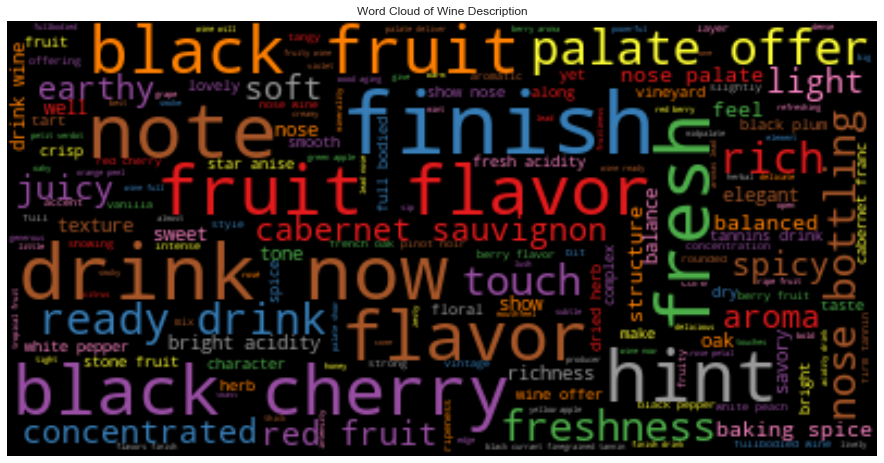

In [229]:
# Check the top words of wine description.
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize= (16,8))
plt.title('Word Cloud of Wine Description')
wc = WordCloud(max_words=1000,max_font_size=40,background_color='black', stopwords = STOPWORDS, colormap='Set1')
wc.generate(' '.join(wine_df['description_c']))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')

Top words: black, drink,, fresh, cherry, flavor, finish, note, ready,  palate, offer, hint, rich, etc.

#### Topic Extraction by LSA, LDA, NNMF

In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer

x =  wine_df['description_c']
# Creating the tf-idf matrix.
tfv = TfidfVectorizer(stop_words="english",
                     lowercase=True,
                     ngram_range=(1, 1), 
                     analyzer='word', 
                     max_df=0.5, 
                     min_df=1,
                     max_features=500, 
                     vocabulary=None, 
                     binary=False
                     )

dp_tfidf = tfv.fit_transform(x)
print(dp_tfidf.shape)


# Getting the word list.
terms = tfv.get_feature_names()
#print(terms)

# Number of topics.
ntopics=3

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 30

(28790, 500)


In [243]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import time

start_time_lsa = time.perf_counter()

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
dp_lsa = lsa.fit_transform(dp_tfidf)

components_lsa = word_topic(dp_tfidf, dp_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)   

runtime = time.perf_counter() - start_time_lsa
print("Runtime_LSA: {} Seconds".format(runtime))

Runtime_LSA: 0.1422037000011187 Seconds


In [244]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

start_time_lda = time.perf_counter()

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None,       # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7,         # Convergence rate.
          learning_offset=10.0,       # Causes earlier iterations to have less influence on the learning
          max_iter=10,                # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1,          # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001,      # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100,    # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1,                  # Use all available CPUs to speed up processing time.
          verbose=0,                  # amount of output to give while iterating
          random_state=0
         )

dp_lda = lda.fit_transform(dp_tfidf) 

components_lda = word_topic(dp_tfidf, dp_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

runtime = time.perf_counter() - start_time_lda
print("Runtime_LDA: {} Seconds".format(runtime))

Runtime_LDA: 23.224659300001804 Seconds


In [245]:
# NNMF
from sklearn.decomposition import NMF

start_time_nmf = time.perf_counter()

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
dp_nmf = nmf.fit_transform(dp_tfidf) 

components_nmf = word_topic(dp_tfidf, dp_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

runtime = time.perf_counter() - start_time_nmf
print("Runtime_NMF: {} Seconds".format(runtime))

Runtime_NMF: 0.39622439999948256 Seconds


In [246]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
               LSA                LDA              NNMF
0  flavors 1292.75      palate 605.85      aromas 41.27
0   palate 1172.67      aromas 575.81      cherry 39.94
0   aromas 1122.28     flavors 452.21     tannins 36.66
0    fruit 1072.32     acidity 412.29      palate 36.22
0   acidity 964.35        nose 409.74       black 35.97
0    finish 905.07       white 406.25     flavors 34.86
0   tannins 890.76       finish 392.3       fruit 29.39
0     drink 841.14       fruit 370.29        plum 28.83
0      nose 837.34       apple 367.67          red 27.9
0      ripe 835.97       lemon 362.72       berry 27.13
0     cherry 788.4      offers 303.06      finish 26.18
0     black 720.18       fresh 301.07         oak 23.89
0        red 672.8      cherry 290.53       spice 23.87
0     fresh 629.25       peach 290.18        nose 22.38
0       oak 629.17      citrus 289.81  blackberry 19.12
0     notes 598.37     tannins 283.12       dried 18.73
0      spice 592.9        ripe 264.17  

Form LDA top words results, we can get three topics:

Topic 0: white/light color wine: (top words: acidity, white, nose, apple, lemmon, offer, fresh)

Topic 1: Red/dark color wine: (top words: black, tannins, oak, red, plum, blackberry) 

Topic 2: Drink/age (mix wines): (top words: drink, aging - drink now or later
                                acidity, crisp, fresh - light color ready to drink
                                tannins, dry, rich, texture, aging - dark color, drink later or need age)


#### Sparsity

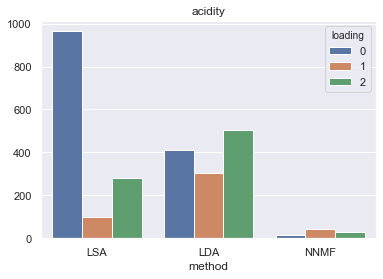

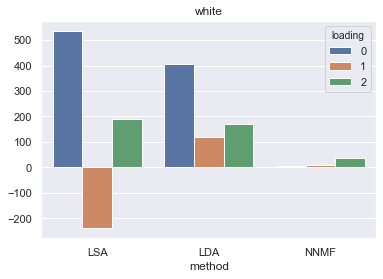

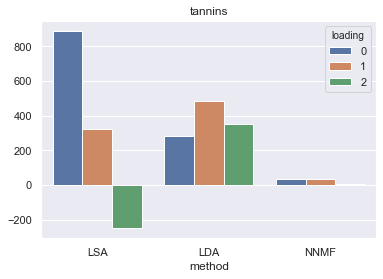

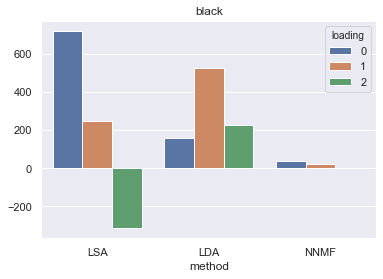

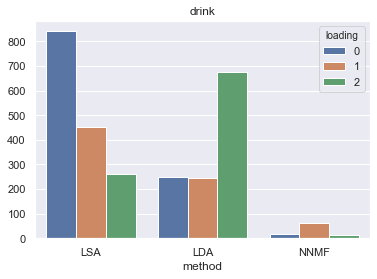

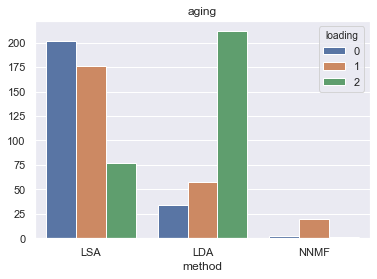

In [250]:
# 3-topic Sparsity
# The words to look at.
targetwords=['acidity','white', 'tannins', 'black', 'drink', 'aging']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 3, axis=0)
wordloadings['loading']=[0,1,2]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

From sparsity results, LDA is the best technique for topic modeling compared with LSA and NNMF. LDA is more consistent than the other LSA and NMF to predict the most features. The negative value leads LSA sometimes hard to understand. 

#### Visualizing LDA results with pyLDAvis

In [251]:
import pyLDAvis
import pyLDAvis.sklearn
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, dp_tfidf, tfv, mds='tsne')

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
1     -1015.700562  1338.981201       1        1  38.146096
0      -387.996002  -373.316162       2        1  32.249913
2     -2184.745605   -60.565800       3        1  29.603991, topic_info=          Term         Freq        Total Category  logprob  loglift
117      drink  1172.000000  1172.000000  Default  30.0000  30.0000
174     fruits   702.000000   702.000000  Default  29.0000  29.0000
351      ready   428.000000   428.000000  Default  28.0000  28.0000
171  freshness   436.000000   436.000000  Default  27.0000  27.0000
20      aromas  1331.000000  1331.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
441    tannins   338.954764  1110.861695   Topic3  -4.5562   0.0302
58      bright   278.438348   630.095805   Topic3  -4.7529   0.4006
172      fruit   327.892451  1249.582752   Topic3  -4.5894  -0.1206
47       blend   254.562706   609.468543   Topic3  -4.8425   0.3442
402       soft   246.606791   516.449750   Topic3  -4.8743   0.4781

[223 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.132751  acidity
2         2  0.346945  acidity
2         3  0.520418  acidity
4         1  0.013156     adds
4         2  0.006578     adds
...     ...       ...      ...
497       1  0.023728    young
497       2  0.003955    young
497       3  0.972851    young
498       2  0.969524     zest
498       3  0.025740     zest

[368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

The above figure shows that topic 1 is about red/dark color wines, topic 2 is about white/light color wines, topic 3 is about drink or age topic.

## Conclusions

1. In general, the wine price increases with rating points. At the same rating points, the price can be varied from low to high price. This is also a good feature for wine customers because they can buy wines with low price and high rating points.
2. In different countries, the price for wines is different. The most expensive wines (average price) are produced by UK followed by Canada and Peru. US is in the 4th place. 
3. Grape type also affects the price of the wine. The most popular wines are not very expensive indicating that they are good for the market and most consumers’ needs.
4. For the same wine variety, both price and rating points are various from low to high. This also gives a good sign for wine consumer that they can buy all kinds of wines with good quality at low price.
5. Supervised Linear regression algorithm could be used for predicting wine rating points with wine description text data. The accuracy for the model is about 64%.
6. Three methods LSA, LDA and NNMF were tested and LDA was proved as a good technique for topic modeling.
7. Three topics (red/dark wines, white/light wines, drink/age wines) were obtained from unsupervised topic extraction model. This could help wine consumers to make decision to buy wines and drink now or age them for later drink.
8. The description text data might be cleaned further to get more topics.